<div align=right>Notebook created by Luzius Meisser, luzius@meissereconomics.com, July 2016</div>

<h1 align=center>Tipping points in macroeconomic agent-based models</h1>

This notebook contains the Mark 0 model presented in "Tipping points in macroeconomic agent-based models" by S. Gualdi, M. Tarzia, F. Zamponi, and JP. Bouchaud. The C source-code was provided by S. Gualdi and translated to Python by me.

It works and produces a reasonable output, but I did not directly verify the results with those from the paper yet. This is just a proof of concept.


In [1]:
# load and configure required modules
%load_ext autoreload
%autoreload 2

import math
import numpy # numerics

import scipy
from scipy import optimize # we use their root finding algorithm
import matplotlib.pyplot as plot
%matplotlib inline

In [7]:
LABELS = ["Day" , "ytot", "t", "bust", "Pavg", "Wavg", "S", "Atot", "firm_savings", "debt_tot", "inflation", "k"]

Gamma = 0.05  # 
gammap = 0.05 # Price adjustment
theta = 0.1
f = 0.5  # 1 - bailout probability
seed = 13
z = 1
gammaw = z*gammap

ZERO = 1.e-50

RENORM = 1

G = 0.5
beta = 2
phi = 0.1
delta = 0.02

numpy.random.seed(13) # Ensuring that 'run all' always yields the exact same result


# eta0m is tendency for decreasing production
# eta0p is tendency for increasing production
def runMark0(T, N, eta0p, eta0m):
    A = [1] * N  # assets
    Y = [None] * N  # production
    D = [0.5] * N  # demand
    P = [None] * N  # price
    W = [1.0] * N  # wage
    PROFITS = [None] * N  # profits
    ALIVE = [1] * N  # dead or alive
    
    Pavg = 0.
    Ytot = 0.
    Wtot = 0.
    Atot = 0.
    Wmax = 1.
    Pold = 1.
    
    for i in range(0, N):
        
        P[i] 	 =  1.  + 0.1*(2*numpy.random.uniform()-1.)
        Y[i] 	 =  0.5 + 0.1*(2*numpy.random.uniform()-1.)
        PROFITS[i] = P[i]*min(D[i],Y[i]) - W[i]*Y[i];
        
        A[i] =  2*Y[i]*W[i]*numpy.random.uniform();
        
        Atot += A[i];
        Ytot += Y[i];
        Pavg += P[i]*Y[i];
        Wtot += Y[i]*W[i];
        
    
    e = Ytot / N
    u = 1. - e
    
    Pavg /= Ytot
    Wavg = Wtot / Ytot # was Wavg /= Ytot 
    
    S = e*N
    
    #fix total amount of money to N
    
    tmp = Atot + S
    S = S*N/tmp
    Atot=0.
    
    for i in range(0, N):
        A[i]  = A[i]*N/tmp
        Atot += A[i]
    
    
    max_u = 0.
    min_u = 2.
    bust = 0.
    
    days = []
    ytots = []
    us = []
    busts = []
    Pavgs = []
    tWavgs = []
    Ss = []
    Atots = []
    firm_savingss = []
    debt_totals = []
    inflations = []
    ks = []
    
    for t in range(0, T):
        
        #renormalize in unit of price.
        if RENORM==1:
            
            for i in range(0, N):
                P[i]/=Pavg
                W[i]/=Pavg
                A[i]/=Pavg
                PROFITS[i] /= Pavg
            
            S    /= Pavg
            Wavg /= Pavg
            Wmax /= Pavg
            Pold /= Pavg
            Pavg  = 1.;
        
      
        #update firms variables
        Wtot = 0.
        Ytot = 0.
        tmp  = 0.
        Pmin = 1.e+300 
        
        if beta>0.:
            wage_norm = 0.
            for i in range(0, N):
                if ALIVE[i]==1:
                    arg = beta*(W[i]-Wmax)/Wavg
                    if arg>-100.:
                        wage_norm += math.exp(arg)

        
        newlist = []
        
        for i in range(0, N):
            
            # living firms update price / production / wages
            if ALIVE[i]==1:
                
                pay_roll = Y[i]*W[i]
                
                if pay_roll>0.:
                    ren = max(-1, min(1, Gamma * A[i] / pay_roll))
                else:
                    ren = 0.
                
                rp = gammap*numpy.random.uniform()
                rw = gammaw*numpy.random.uniform()
                
                dY = D[i] - Y[i] 
                p  = P[i]
                
                if beta>0.:
                    arg = beta*(W[i]-Wmax)/Wavg 
                    u_share = 0.
                    if arg>-100.:
                        u_share = u * N * (1.-bust) * math.exp(arg) / wage_norm
                else:
                    u_share = u
                
                #excess demand
                if dY>0.:
                    
                    #increase production
                    Y[i] += min(eta0p*(1.+ren)*dY,u_share)
                    
                    #increase price
                    if p<Pavg:
                        P[i] *= (1. + rp) 
                    
                    #increase wage
                    if PROFITS[i]>0. and z>ZERO:
                        W[i] *= 1. + (1. + ren)*rw*e
                        W[i] = min(W[i],P[i]*min(D[i],Y[i])/Y[i])
                
                #excess production
                else:
                    
                    #decrease production
                    Y[i] += eta0m*(1.-ren)*dY
                    
                    #decrease price
                    if p>Pavg:
                        P[i] *= (1. - rp)
                    
                    #decrease wage
                    if PROFITS[i]<0. and z>ZERO:
                        W[i] *= 1. - (1.-ren)*rw*u
                
                
                Y[i] = max(Y[i],0.)
                
                Wtot += W[i]*Y[i]
                tmp  += P[i]*Y[i]
                Ytot += Y[i]
                Pmin = min(Pmin,P[i])
                
                if P[i]>1.e+300 or P[i]<1.e-300:
                    "Price overflow"
                    exit
            else:
                newlist.append(i)
        
        Pavg = tmp / Ytot
        Wavg = Wtot / Ytot
        e = Ytot / N
        u = 1. - e
        
        # Consumption
        
        propensity = G
        
        budget = propensity * ( Wtot + max(S,0.) )
        
        Pnorm = 0.
        for i in range(0, N):
            if ALIVE[i]==1:
                arg = beta*(Pmin-P[i]) / Pavg 
                if arg>-100.:
                    Pnorm += math.exp(arg)
        
        firm_savings=0.
        badlist = []
        
        for i in range(0, N):
            if ALIVE[i]==1:
                D[i] = 0.
                arg = beta*(Pmin-P[i])/Pavg 
            
            if arg>-100.:
                D[i] = budget * math.exp(arg) / Pnorm / P[i]
            
            PROFITS[i] = P[i]*min(Y[i],D[i]) - Y[i]*W[i]
            
            S    -= PROFITS[i]
            A[i] += PROFITS[i]
            
            if A[i]>0. and PROFITS[i]>0.:
                S    += delta*PROFITS[i]
                A[i] -= delta*PROFITS[i]
            
            #create lists
            if theta>-0.5 and A[i] < -theta*W[i]*Y[i]:
                badlist.append(i)

            firm_savings += max(A[i],0.)
        
        # ******************************* BANKRUPTCY & REVIVAL ********************************
        
        #bankrupcty
        deftot=0.;
        
        for bad_firm in badlist:  
            deftot -= A[bad_firm]
            Y[bad_firm] = 0.
            ALIVE[bad_firm] = 0
            A[bad_firm] = 0.
            newlist.append(bad_firm)
        
        #revival
        for new_firm in newlist:  
            if numpy.random.uniform()<phi:
                Y[new_firm] = max(u,0.)*numpy.random.uniform()
                ALIVE[new_firm] = 1
                P[new_firm] = Pavg
                W[new_firm] = Wavg
                A[new_firm] = W[new_firm]*Y[new_firm]
                firm_savings += A[new_firm]
                PROFITS[new_firm] = 0.
            
                deftot += A[new_firm]
        
        #spread debt
        
        tmp = f*S+(1.-f)*firm_savings
        
        fS = f*S/tmp
        fA = (1.-f)*firm_savings/tmp
        
        S_bill = fS*deftot 
        A_bill = fA*deftot 
        
        if S>S_bill:
            S -= S_bill
            S_bill=0.
        else:
            S_bill -= S
            S = 0.
        
        A_bill += S_bill
        
        
        # ******************************* FINAL ******************************** */
        
        #new averages
        tmp  = 0.
        Ytot = 0.
        Wtot = 0.
        bust = 0.
        Atot = 0.
        Wmax = 0.
        debt_tot = 0.
        Pnorm = firm_savings
        firm_savings = 0.
        
        
        for i in range(0, N):
            
            #final averages
            if ALIVE[i]==1:
                
                if A[i]>0.:
                    A[i] -= A_bill*A[i]/Pnorm
                
                Wtot    += Y[i]*W[i]
                Ytot    += Y[i]
                tmp     += P[i]*Y[i]
                Atot    += A[i]
                firm_savings    +=  max(A[i],0.)
                debt_tot        += -min(A[i],0.)
                
                Wmax = max(W[i],Wmax)
            
            if ALIVE[i]==0:
                bust += 1./N
        
        Pavg = tmp / Ytot
        Wavg = Wtot / Ytot
        
        e = Ytot / N
        
        if e-1>1.e-10 or e<-ZERO or S<0.:
            "error" + e
            exit
        
        e = min(e,1.)
        e = max(e,0.)
        
        u =  1. - e
        
        inflation = (Pavg-Pold)/Pold
        Pold = Pavg
        
        if Ytot<1.e-07:
            print("Collapse")
            t=T;
        
        k = debt_tot / (firm_savings+S)
        
        days.append(t)
        ytots.append(Ytot)
        us.append(u)
        busts.append(bust)
        Pavgs.append(Pavg)
        tWavgs.append(Wavg)
        Ss.append(S)
        Atots.append(Atot)
        firm_savingss.append(firm_savings)
        debt_totals.append(debt_tot)
        inflations.append(inflation)
        ks.append(k)
    
    return [days, ytots, us, busts, Pavgs, tWavgs, Ss, Atots, firm_savingss, debt_totals, inflations, ks]

    


In [21]:
result = runMark0(T=3000, N=100, eta0p=0.2, eta0m=0.1)

Plotting ytot


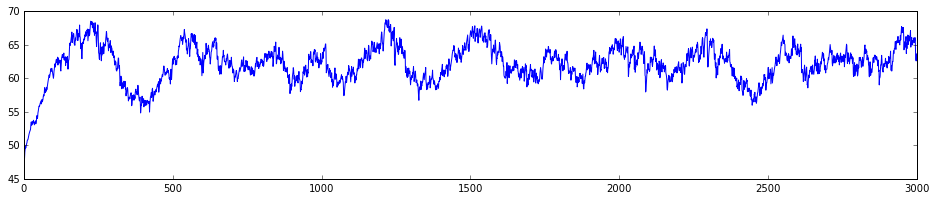

Plotting t


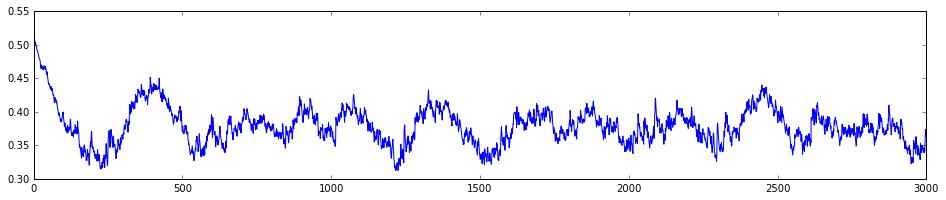

Plotting bust


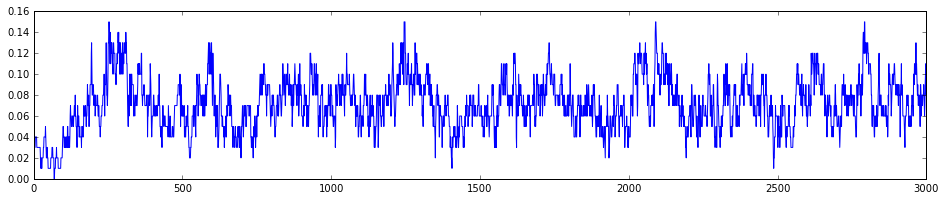

Plotting Pavg


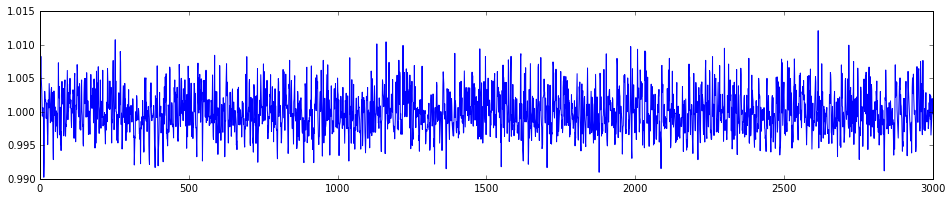

Plotting Wavg


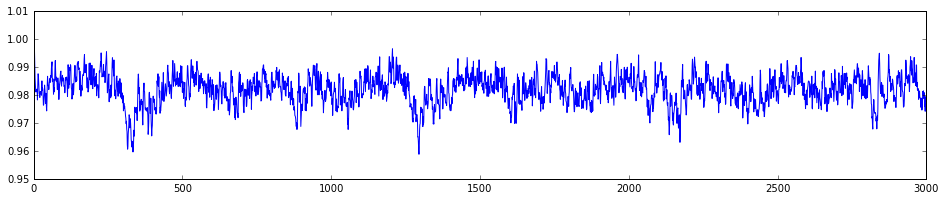

Plotting S


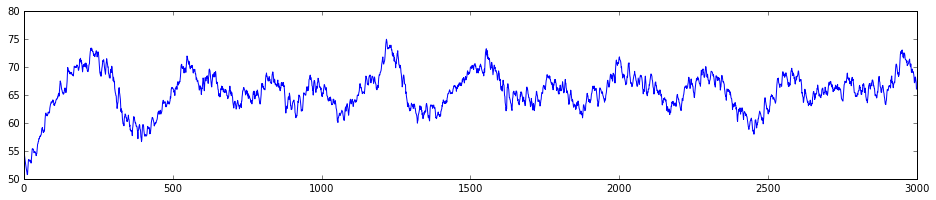

Plotting Atot


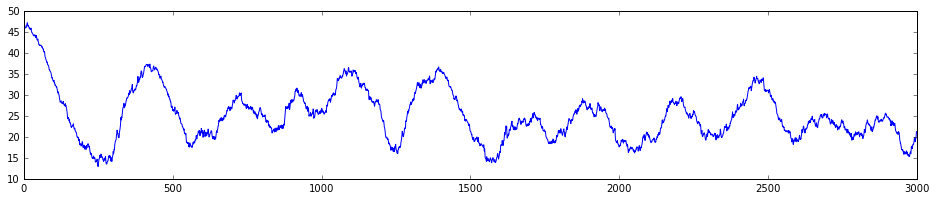

Plotting firm_savings


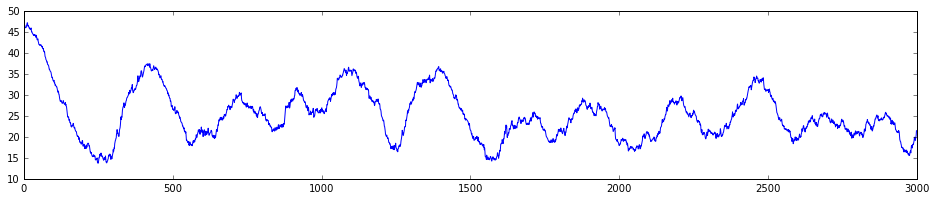

Plotting debt_tot


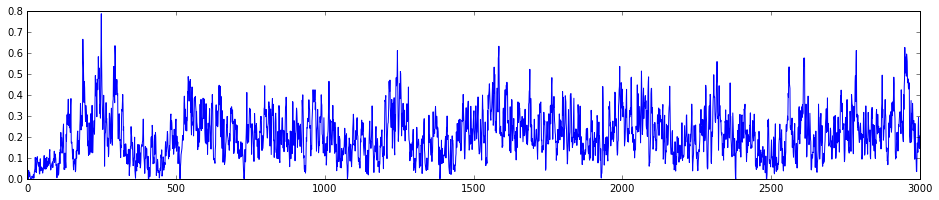

Plotting inflation


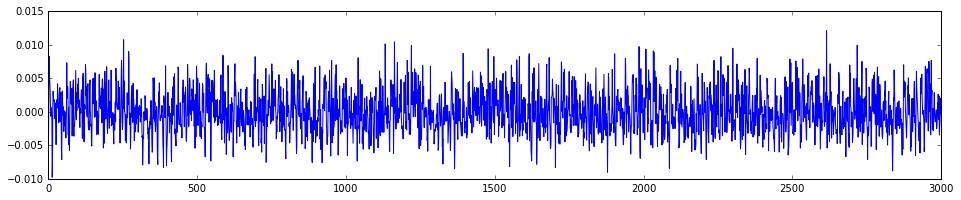

Plotting k


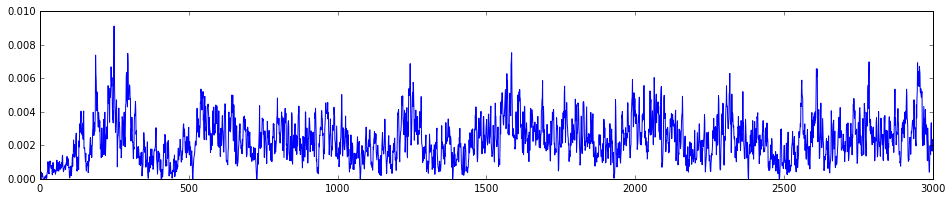

In [22]:
def plotResult(variable):
    print("Plotting " + LABELS[variable])
    plot.figure(figsize=(16,3))
    plot.plot(result[variable])
    plot.show()
    
for var in range(1, len(LABELS)):
    plotResult(var)